<h1>Lesson 1: What's your pet? - An image classifier from scratch<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Looking-at-the-data" data-toc-modified-id="Looking-at-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Looking at the data</a></span></li><li><span><a href="#Training:-resnet34" data-toc-modified-id="Training:-resnet34-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training: resnet34</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Unfreezing,-fine-tuning,-and-learning-rates" data-toc-modified-id="Unfreezing,-fine-tuning,-and-learning-rates-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Unfreezing, fine-tuning, and learning rates</a></span></li><li><span><a href="#Training:-resnet50" data-toc-modified-id="Training:-resnet50-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training: resnet50</a></span></li><li><span><a href="#Other-data-formats" data-toc-modified-id="Other-data-formats-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Other data formats</a></span></li></ul></div>

## Introduction

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first **image classifier from scratch**, and see if we can achieve world-class results. Let's dive in!

### Imports

Every notebook executed in a local environment starts with the same three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook. In a cloud environment we may need to update the fastai version or install some libs.

In [0]:
%%capture
from notebook import notebookapp
server = list(notebookapp.list_running_servers())[0]

if server['hostname'] == 'localhost':
  # Local environment
  %reload_ext autoreload
  %autoreload 2
  %matplotlib inline
else:
  # Cloud
  !pip install git+https://github.com/fastai/fastai.git#@b4872c7217932d382b0e08ef8458b0b7cb6dc9f8
  !curl https://course.fast.ai/setup/colab | bash

In [2]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.53.dev0
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-r

We import all the necessary packages. We are going to work with the [**fastai** V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [**Pytorch** 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with a small GPU, you may get an out of memory error when running this notebook (especially with the resnet50 model). If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (it'll last longer), and try again.

In [0]:
bs = 64
#bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features **12 cat breeds** and **25 dogs breeds**. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [5]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [6]:
path = untar_data(URLs.PETS); path

PosixPath('/content/data/oxford-iiit-pet')

In [7]:
path.ls()

[PosixPath('/content/data/oxford-iiit-pet/annotations'),
 PosixPath('/content/data/oxford-iiit-pet/images')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html). We use `get_image_files` to filter images based on the file extensions.

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/content/data/oxford-iiit-pet/images/basset_hound_153.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/wheaten_terrier_119.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/shiba_inu_110.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/staffordshire_bull_terrier_34.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/saint_bernard_129.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [11]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
basset_hound,wheaten_terrier,shiba_inu,Ragdoll,Bombay
Path: /content/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
great_pyrenees,havanese,havanese,leonberger,american_pit_bull_terrier
Path: /content/data/oxford-iiit-pet/images;

Test: None

224x224 size is a very common one (it works well). Normalization is applied also because it's necessary in deep learning problems (tipically with mean 0, std dev 1).

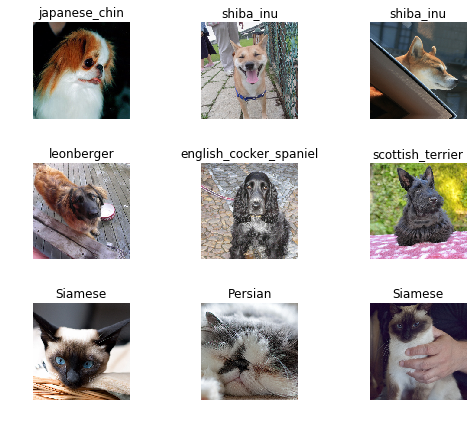

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)
data.c # equivalent to len(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


37

## Training: resnet34

Now we will start training our model. We will use a [**convolutional neural network (CNN)**](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and **will output the predicted probability for each of the categories** (in this case, it will have 37 outputs).

We'll use a **CNN learner** (something that knows how to build a model using a CNN for us). We pass the data and the base architecture to it (**resnet34** works extremely well by nearly everything; resnet50 too, but it's bigger and slower). We will train the model for 4 epochs (4 cycles through all our data).

In [14]:
doc(cnn_learner)

In [0]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate)

It downloaded the resnet34 architecture for pre-trained weights (it was trained for **ImageNet**; a dataset with 1,5 million of images). This is better than starting the training from scratch, because resnet34 knows how to recognize a lot of things. This is called **Transfer Learning**.

In [16]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

We'll use **one cycle** to fit the model (`fit_one_cycle`), as is the most accurate and fast approach to do that. The parameter (number of epochs or cycles) says how many times it runs through the whole dataset (we'll learn to choose it in further lessons). The value of 4 is a good starting point.

In [17]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.397551,0.335606,0.100812,01:29
1,0.558278,0.260958,0.084574,01:28
2,0.349589,0.226039,0.069012,01:27
3,0.263188,0.216416,0.062923,01:27


A lot lot better than in the original paper!

Let's save the model so we don't have to train it again (same location as data):

In [0]:
learner.save('stage-1')

## Results

Let's see what results we have got. **Interpretation of the model** is done by using the fastai class `ClassificationInterpretation` and its methods:

In [0]:
interp = ClassificationInterpretation.from_learner(learner)

We will first see which were the categories that the model **most confused** with one another, by using `top_losses()`. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

In [20]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

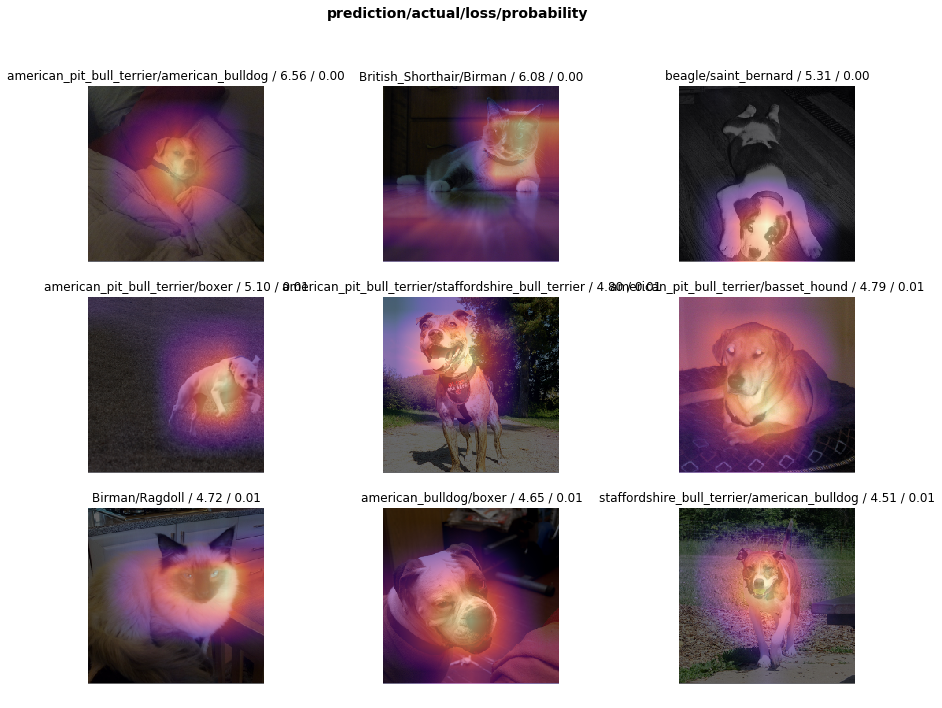

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

In [22]:
doc(interp.plot_top_losses)
# Summary: "Show images in top_losses along with their prediction, actual, loss, and probability of actual class."
# And... a link to the online docs :)

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

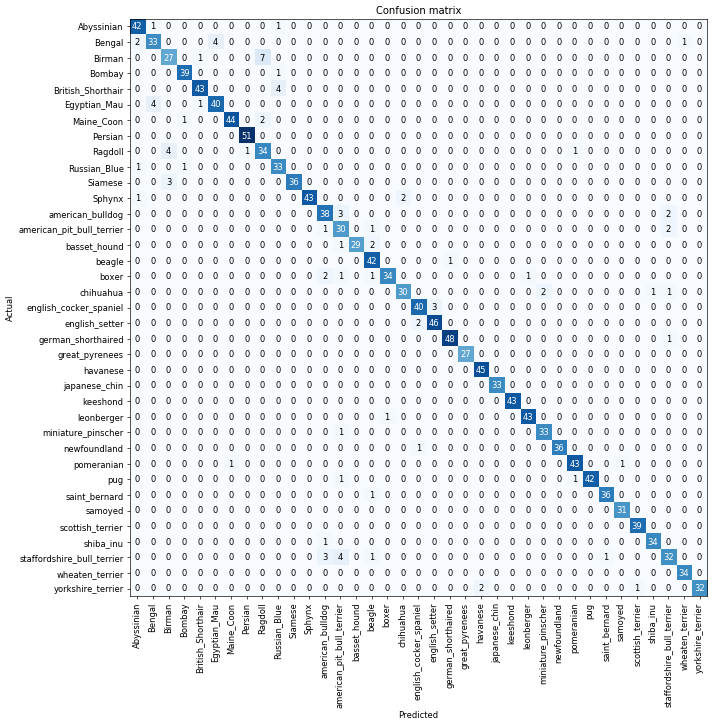

In [23]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Instead of that, we can use the `most_confused` method!

In [24]:
interp.most_confused(min_val=2)

[('Birman', 'Ragdoll', 7),
 ('Bengal', 'Egyptian_Mau', 4),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Ragdoll', 'Birman', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Siamese', 'Birman', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 2),
 ('basset_hound', 'beagle', 2),
 ('boxer', 'american_bulldog', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('yorkshire_terrier', 'havanese', 2)]

Next, we'll try to make our model better. With applying `fit_one_cycle` to our learner, we just add extra layers and train those only. This called first stage. At a second stage, we try to train the whole model.

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will `unfreeze` our model and train the whole model (not only the added layers). By default, when you load a model from fastai (resnet, others), it will have all the layers frozen (with pre-trained weights, not modifiable). With `summary` we'll know which layers are already freezed.

In [25]:
learner.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________

In [26]:
learner.unfreeze()
learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.524676,0.306720,0.100135,01:28


The result is way worse training the whole model. It makes sense, because does not make sense to train the first layers again (we can't easily improve the resnet layers). Let's back to our prior weights...

In [0]:
learner.load('stage-1');

Let’s run learning rate finder. It figures out what is the fastest rate I can train the model at.

In [28]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


We plot the results from the learning rate finder:

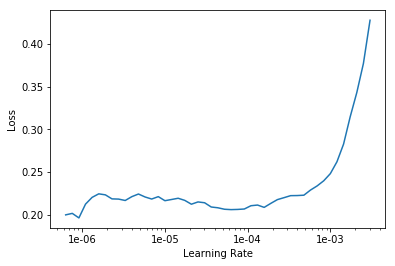

In [29]:
learner.recorder.plot()

The default learning rate for learn.fit_one_cycle is 0.003, which appears to be a bad one. We'll unfreeze the learner again and **specify a better learning rate**; it could be 1e-06, but we can train it faster, inside a range (start LR to stop LR) where it won't become worse (until 1e-04). So the highest specified learning rate will be used for the last layers, demanding the most changing; and the lowest for the resnet layers, which are well adjusted and need less changes. As a rule of thumb: choose the stop LR 10 times below the stage-1's LR (0.0003 vs 0.003).

In [36]:
learner.unfreeze()
learner.fit_one_cycle(2, max_lr=slice(1e-6,5e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.230468,0.212434,0.060217,01:29
1,0.211437,0.205392,0.057510,01:30


That's a pretty accurate model! with these 2 stages it should be enough to get a world class model. Maybe you won't win a Kaggle competition, but you'll get pretty the same results as the vast majority of practitioners. We could add more layers (resnet50), and try another things.

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use **resnet50** (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=48).normalize(imagenet_stats)

In [38]:
learner = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 97104332.19it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


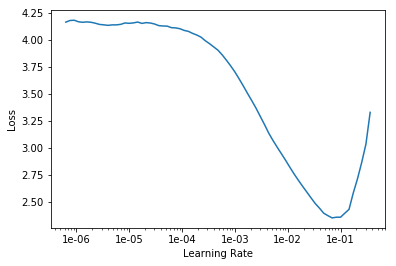

In [39]:
learner.lr_find()
learner.recorder.plot()

In [41]:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.229783,0.198330,0.069689,02:15
1,0.261090,0.239597,0.076455,02:14
2,0.247071,0.216208,0.064276,02:15
3,0.195097,0.224785,0.069012,02:15
4,0.158481,0.182752,0.057510,02:17
5,0.117185,0.176897,0.056157,02:14
6,0.085628,0.176363,0.054804,02:17
7,0.066362,0.173997,0.054127,02:15


In [0]:
learner.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


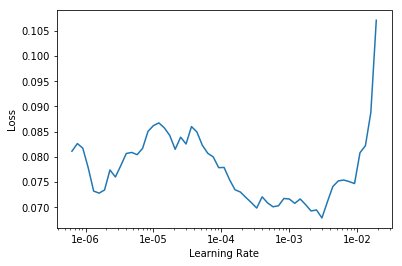

In [43]:
learner.lr_find()
learner.recorder.plot()

In [45]:
learner.load('stage-1-50')
learner.unfreeze()
learner.fit_one_cycle(3, max_lr=slice(1e-6,2e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.166735,0.216166,0.061570,02:28
1,0.140157,0.196892,0.062923,02:25
2,0.076872,0.170433,0.050744,02:24


In [46]:
learner.load('stage-1-50')
learner.unfreeze()
learner.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.095582,0.176655,0.056834,02:26
1,0.117866,0.198803,0.056157,02:24
2,0.068059,0.169000,0.044655,02:24


If it doesn't, you can always go back to your previous model.

In [0]:
#learner.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learner)

In [49]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'american_bulldog', 4),
 ('Birman', 'Ragdoll', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('basset_hound', 'beagle', 3),
 ('english_cocker_spaniel', 'havanese', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('wheaten_terrier', 'havanese', 3),
 ('Bengal', 'Egyptian_Mau', 2),
 ('beagle', 'german_shorthaired', 2),
 ('boxer', 'american_bulldog', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('samoyed', 'great_pyrenees', 2)]

## Other data formats

In [50]:
path = untar_data(URLs.MNIST_SAMPLE)
path

PosixPath('/root/.fastai/data/mnist_sample')

In [51]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_sample/valid'),
 PosixPath('/root/.fastai/data/mnist_sample/train'),
 PosixPath('/root/.fastai/data/mnist_sample/labels.csv')]

In [52]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/mnist_sample/train/3'),
 PosixPath('/root/.fastai/data/mnist_sample/train/7')]

The labels are the folder names. So we'll use the `from_folder` method.

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

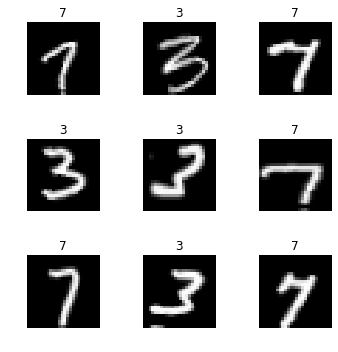

In [54]:
data.show_batch(rows=3, figsize=(5,5))

In [55]:
learner = cnn_learner(data, models.resnet18, metrics=accuracy)
learner.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 155025312.38it/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.177238,0.074541,0.972522,00:19
1,0.094174,0.049350,0.979392,00:18


Another option is to have the labels in a CSV file. We'll load those in a dataframe, and later we'll use the `from_df` method

In [56]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

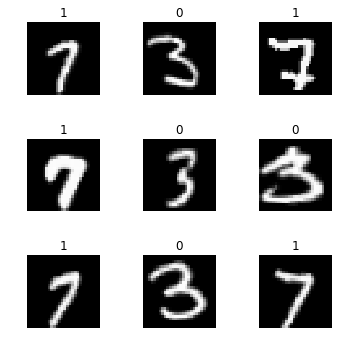

In [58]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [59]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

Another possibility when the label is the directory name:

In [60]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [61]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

Or we can use a function and the `from_name_func` method:

In [62]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

Or directly the labels and the `from_lists` function:

In [63]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [64]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']